# import statement and load data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [48]:
image_dir = 'images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

# Preprocess the data to be the same as the ImageNet ones
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize directly because images are square
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# # Load the dataset using ImageFolder
# image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# # Create a data loader to iterate through the dataset in batches
# data_loader = DataLoader(image_dataset, batch_size=32, shuffle=True)

# # The labels are automatically assigned based on the folder names
# print(image_dataset.class_to_idx) # should only have class 0 through 4

# # Iterate through the data loader
# for images, labels in data_loader:
#     # Process the images and labels
#     print(images.shape, labels.shape)
#     break

Using cuda device.


# finetune the pretrained resnet18 model

In [49]:
model = models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 5) # replace the final layer to only predict on 5 classes

In [50]:
# split the model taking note of class imbalance into train/test set
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

# load full dataset
image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# extract labels
targets = np.array(image_dataset.targets)

# stratified split to account for class imbalance
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(np.zeros(len(targets)), targets))

# create subset datasets
train_dataset = Subset(image_dataset, train_idx) # recover the same class labels as the original dataset
test_dataset = Subset(image_dataset, test_idx)

# initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# use loss reweighting to pretrain
class_counts = np.bincount(targets, minlength=num_classes)
total_samples = len(targets)

# Inverse frequency weighting
class_weights = total_samples / (num_classes * class_counts)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Now use in loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [61]:
class_counts

array([3750,  272,  568,   82,  212])

In [62]:
class_weights

array([ 0.26048   ,  3.59117647,  1.71971831, 11.91219512,  4.60754717])

In [55]:
# define loss function and optimizer
# loss_fn = nn.CrossEntropyLoss() # softmax loss, common for training multiclass classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [63]:
# training loop
num_epochs = 30
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # raw logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # For metrics
        probs = F.softmax(outputs, dim=1)  # convert logits to probs
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)

    # Compute metrics
    epoch_acc = accuracy_score(all_labels, all_preds)

    try:
        epoch_auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    except ValueError:
        epoch_auroc = float('nan')  # handle case where AUROC can't be computed

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - "
          f"Accuracy: {epoch_acc:.4f} - AUROC (OVR): {epoch_auroc:.4f}")


Epoch 1/30 - Loss: 1.1686 - Accuracy: 0.6043 - AUROC (OVR): 0.7979
Epoch 2/30 - Loss: 0.6587 - Accuracy: 0.7172 - AUROC (OVR): 0.9247
Epoch 3/30 - Loss: 0.3134 - Accuracy: 0.8661 - AUROC (OVR): 0.9817
Epoch 4/30 - Loss: 0.1653 - Accuracy: 0.9209 - AUROC (OVR): 0.9950
Epoch 5/30 - Loss: 0.0692 - Accuracy: 0.9713 - AUROC (OVR): 0.9992
Epoch 6/30 - Loss: 0.0356 - Accuracy: 0.9887 - AUROC (OVR): 0.9998
Epoch 7/30 - Loss: 0.0162 - Accuracy: 0.9969 - AUROC (OVR): 1.0000
Epoch 8/30 - Loss: 0.0073 - Accuracy: 0.9992 - AUROC (OVR): 1.0000
Epoch 9/30 - Loss: 0.0054 - Accuracy: 1.0000 - AUROC (OVR): 1.0000
Epoch 10/30 - Loss: 0.0040 - Accuracy: 0.9997 - AUROC (OVR): 1.0000
Epoch 11/30 - Loss: 0.0054 - Accuracy: 0.9992 - AUROC (OVR): 1.0000
Epoch 12/30 - Loss: 0.0104 - Accuracy: 0.9980 - AUROC (OVR): 0.9999
Epoch 13/30 - Loss: 0.0066 - Accuracy: 0.9987 - AUROC (OVR): 1.0000
Epoch 14/30 - Loss: 0.0061 - Accuracy: 0.9985 - AUROC (OVR): 1.0000
Epoch 15/30 - Loss: 0.0084 - Accuracy: 0.9977 - AUROC (OV

KeyboardInterrupt: 

# evaluate the performance on test set

In [64]:
torch.save(model.state_dict(), 'finetuned_resnet18_may12.pth')

In [65]:
model = model.eval()
all_outputs = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device) # send to gpu
        labels = labels.to(device)
        
        outputs = model(inputs)
        true_labels.append(labels)
        all_outputs.append(outputs)

In [66]:
all_outputs_cat = torch.cat(all_outputs, dim=0)
predicted = torch.argmax(all_outputs_cat, dim=1)
true_labels = torch.cat(true_labels, dim=0)

In [67]:
print(f'Accuracy: {accuracy_score(true_labels.cpu(), predicted.cpu())}')

Accuracy: 0.8229273285568065


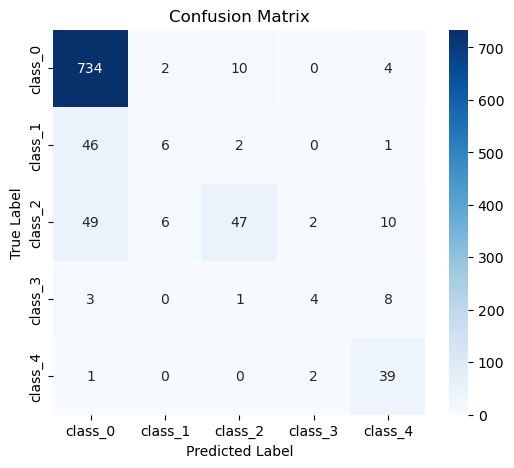

In [43]:
cf = confusion_matrix(true_labels.cpu(), predicted.cpu())
# Get class labels (from the dataset)
class_names = list(image_dataset.class_to_idx.keys())

# Create labeled DataFrame
cf_df = pd.DataFrame(cf, index=class_names, columns=class_names)b

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cf_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [45]:
print(classification_report(true_labels.cpu(), predicted.cpu()))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       750
           1       0.43      0.11      0.17        55
           2       0.78      0.41      0.54       114
           3       0.50      0.25      0.33        16
           4       0.63      0.93      0.75        42

    accuracy                           0.85       977
   macro avg       0.64      0.54      0.54       977
weighted avg       0.83      0.85      0.82       977



In [44]:
from collections import Counter

# test_dataset is a Subset of image_dataset
subset_labels = [image_dataset.targets[i] for i in test_dataset.indices]

# Count occurrences per class
class_counts = Counter(subset_labels)
print(class_counts)

Counter({0: 750, 2: 114, 1: 55, 4: 42, 3: 16})


# save finetuned model weights

In [21]:
torch.save(model.state_dict(), "resnet_finetuned.pth")

In [38]:
torch.save(model, "resnet_finetuned_full.pt")

# load saved weights and run on test set again

In [9]:
model = models.resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, 5)  # restore architecture
model.load_state_dict(torch.load("resnet_finetuned.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [82]:
model = model.eval() # inference time!
all_outputs = []
all_labels = []

with torch.no_grad():  # very important! disables gradients (faster, no memory waste)
    for inputs, labels in balanced_loader:  # usually dataloader returns (input, label) tuples
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)  # forward pass batch through model
        all_outputs.append(outputs)  # collect outputs (move to CPU to save GPU memory)
        all_labels.append(labels)

In [85]:
# evaluate performance
# true_labels = torch.tensor(image_dataset.targets)
all_outputs_cat = torch.cat(all_outputs, dim=0)
all_labels_cat = torch.cat(all_labels, dim=0).cpu()
predicted = torch.argmax(all_outputs_cat, dim=1).cpu()
# comparison = torch.stack((true_labels.to(device), predicted), dim = 1)

true = all_labels_cat.cpu()
preds = predicted.cpu()
probs = nn.functional.softmax(all_outputs_cat, dim=1).cpu().numpy()

In [86]:
from sklearn.metrics import roc_auc_score, accuracy_score
acc = accuracy_score(true, preds)
auroc= roc_auc_score(true, probs, multi_class='ovr')

print(f'Accuracy: {acc} | AUROC: {auroc}')

Accuracy: 0.8853658536585366 | AUROC: 0.9863474122546103


In [87]:
prefix = f'may10_T'
np.save(f'{prefix}/true.npy', true.numpy())
np.save(f'{prefix}/preds.npy', preds.numpy())
np.save(f'{prefix}/probs.npy', probs)

In [75]:
prefix = f'may10_T'
true = np.load(f'{prefix}/true.npy')
preds = np.load(f'{prefix}/preds.npy')
probs = np.load(f'{prefix}/probs.npy')

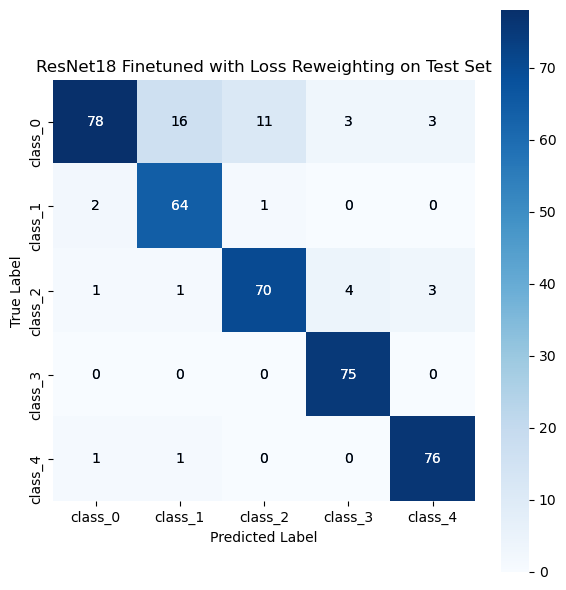

In [88]:
from common_functions import plot_cf
foo = plot_cf(true, preds, 'ResNet18 Finetuned with Loss Reweighting on Test Set')

In [89]:
foo.savefig('finetuned_cf_balanced', bbox_inches='tight', dpi=300)

# finetune on a balanced dataset

In [80]:
import random
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

# group indices by class label
class_indices = {
    '0': np.arange(0, 3750, 1),
    '1': np.arange(3750, 4022, 1),
    '2': np.arange(4022, 4590, 1),
    '3': np.arange(4590, 4672, 1),
    '4': np.arange(4672, 4884, 1)
}

min_class_size = 82

# sample equal number of images per class
balanced_indices = []
for label, idxs in class_indices.items():
    sampled = random.sample(sorted(idxs), min_class_size)
    balanced_indices.extend(sampled)

# Create full dataset
full_dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Create Subsets
balanced_dataset = Subset(full_dataset, balanced_indices)

all_indices = list(range(len(balanced_dataset)))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)

# wrap split data in Subset
train_dataset = Subset(balanced_dataset, train_idx)
test_dataset = Subset(balanced_dataset, test_idx)

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [81]:
balanced_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=False)

In [37]:
model = models.resnet18(weights='DEFAULT')

# freeze all layers except for the last one
# for param in model.parameters():
#     param.requires_grad = False

# replace the classifier (fc) with a trainable one
num_features = model.fc.in_features
num_classes = 5  # or whatever your number of output classes is

model.fc = nn.Linear(num_features, num_classes)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [38]:
# training loop
num_epochs = 30
model.to(device)
model.train()

for epoch in range(num_epochs):
    running_loss = 0
    
    for inputs, labels in train_loader:
        print(f'New inputs, labels')
        inputs = inputs.to(device) # send to gpu
        labels = labels.to(device)

        optimizer.zero_grad() # clear previous gradients
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0) # update loss by the entire dataset size
        
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
Epoch 1/30 - Loss: 1.6952
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
Epoch 2/30 - Loss: 1.5122
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
Epoch 3/30 - Loss: 1.4326
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
New inputs, labels
Epoch 4/30 - Loss: 1.3405
New inputs, labels
New inputs, labels
New inputs, labels
New

In [40]:
model = model.eval() # inference time!
all_outputs = []
all_labels = []

with torch.no_grad():  # very important! disables gradients (faster, no memory waste)
    for inputs, labels in test_loader:  # usually dataloader returns (input, label) tuples
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)  # forward pass batch through model
        all_outputs.append(outputs)  # collect outputs (move to CPU to save GPU memory)
        all_labels.append(labels)

# evaluate performance
# true_labels = torch.tensor(image_dataset.targets)
all_outputs_cat = torch.cat(all_outputs, dim=0)
all_labels_cat = torch.cat(all_labels, dim=0).cpu()
predicted = torch.argmax(all_outputs_cat, dim=1).cpu()
# comparison = torch.stack((true_labels.to(device), predicted), dim = 1)

true = all_labels_cat.cpu()
preds = predicted.cpu()
probs = nn.functional.softmax(all_outputs_cat, dim=1).cpu().numpy()

In [41]:
from sklearn.metrics import roc_auc_score, accuracy_score
acc = accuracy_score(true, preds)
auroc= roc_auc_score(true, probs, multi_class='ovr')

print(f'Accuracy: {acc} | AUROC: {auroc}')

Accuracy: 0.4146341463414634 | AUROC: 0.7504789504157835


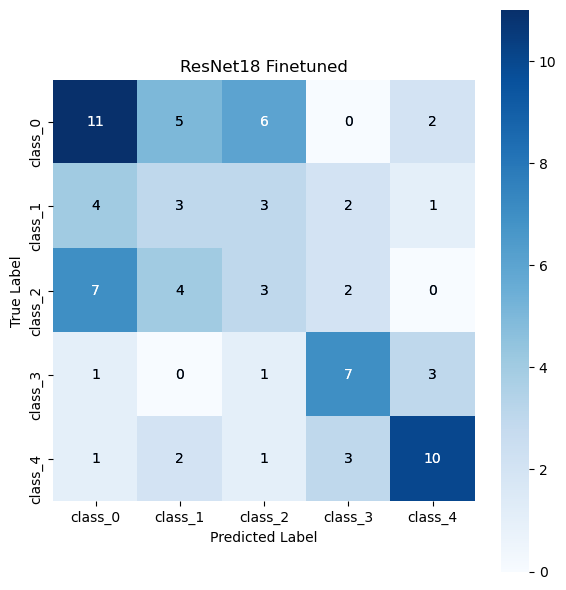

In [42]:
from common_functions import plot_cf
foo = plot_cf(preds, true, 'ResNet18 Finetuned')